In [1]:
import os, warnings, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score
from pdpbox import pdp

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

# Constant

In [2]:
pba_to_lbcs={
    1: '9000',   # Vacant => Agriculture, forestry, fishing and hunting
    2: '2400',   # Office => Business, professional, scientific, and technical services
    4: '2400',   # Laboratory => Business, professional, scientific, and technical services
    5: '3000',   # Nonrefrigerated warehouse => Manufacturing and wholesale trade
    6: '2500',   # Food sales => Food services
    7: '6400',   # Public order and safety => Public Safety
    8: '6500',   # Outpatient health care => Health and human services
    11: '3000',  # Refrigerated warehouse => Manufacturing and wholesale trade
    12: '6600',  # Religious worship => Religious institutions
    13: '5000',  # Public assembly => Arts, entertainment, and recreation
    14: '6100',  # Education => Educational services
    15: '2500',  # Food service => Food services
    16: '6500',  # Inpatient health care => Health and human services
    17: '6500',  # Nursing => Health and human services
    18: '1300',  # Lodging =》Hotels, motels, or other accommodation services
    23: '2100',  # Strip shopping mall => Retail sales or service
    24: '2100',  # Enclosed mall => Retail sales or service
    25: '2100',  # Retail other than mall => Retail sales or service
    26: '4300',  # Service => Utilities and utility services
    91: '9000',  # Other => Agriculture, forestry, fishing and hunting
}

climate = {
    1: 'Very cold/Cold',
    2: 'Mixed-humid',
    3: 'Hot-dry/Mixed-dry/Hot-humid',
    5: 'Marine',
    7: 'Withheld to protect confidentiality'
}

# Commercial Model

In [3]:
dpath = 'cities/shenzhen/raw/building_energy/2012_public_use_data_aug2016.csv'
data = pd.read_csv(dpath)


data.loc[data['NFLOOR']==994, 'NFLOOR']=20
data.loc[data['NFLOOR']==995, 'NFLOOR']=30
# data['AGE'] = data.apply(lambda row: row['YRCONC'], axis=1)
data['LBCS'] = data.apply(lambda row: pba_to_lbcs[row['PBA']], axis=1)
data['SQM'] = 0.092 * data['SQFT']
data['CLIMATE'] = data.apply(lambda row: climate[int(row['PUBCLIM'])], axis=1)

numerical_regressors = ['NFLOOR','NWKER', 'SQM']
categorical_regressors = ['LBCS', 'CLIMATE']
target = 'MFBTU'

data = data[numerical_regressors + categorical_regressors + [target]]
data = data.loc[~data[target].isnull()]
data.head()

,NFLOOR,NWKER,SQM,LBCS,CLIMATE,MFBTU
0,1,2,220.8,4300,Very cold/Cold,26934.0
1,1,52,10488.0,2100,Mixed-humid,5889672.0
2,1,10,234.6,2500,Very cold/Cold,38893.0
3,20,165,46000.0,1300,Mixed-humid,48437214.0
4,2,19,2760.0,2400,Hot-dry/Mixed-dry/Hot-humid,1916844.0


In [4]:
features = numerical_regressors.copy()
for cat_reg in categorical_regressors:
    new_dummies = pd.get_dummies(data[cat_reg], prefix=cat_reg, drop_first=False)
    data = pd.concat([data, new_dummies], axis=1)
    features += new_dummies.columns.tolist()

X = np.array(data[features])
y = np.array(data[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)



print('Traning data shape: ', X_train.shape)
print('Traning target shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test target shape: ', y_test.shape)

Traning data shape:  (5243, 20)
Traning target shape:  (5243,)
Test data shape:  (1311, 20)
Test target shape:  (1311,)


# Linear Regression

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

equation = '{} = {:4.4f}'.format(target, lr.intercept_)
for fea_name, coeff in zip(features, lr.coef_):
    if coeff > 0:
        this_str = ' + {:4.2f} * {}'.format(coeff, fea_name)
    else:
        this_str = ' - {:4.2f} * {}'.format(-coeff, fea_name)
    equation += this_str
print(f'Linear Regerssion Equation:\n{equation}')
        

Linear Regerssion Equation:
MFBTU = 9548721.3076 - 798456.33 * NFLOOR + 42947.85 * NWKER + 890.77 * SQM + 1864341.69 * LBCS_1300 - 5432435.79 * LBCS_2100 - 11810815.75 * LBCS_2400 - 751440.66 * LBCS_2500 - 9877400.55 * LBCS_3000 - 2731566.41 * LBCS_4300 + 6303586.02 * LBCS_5000 - 4442103.02 * LBCS_6100 - 515037.70 * LBCS_6400 + 26544495.62 * LBCS_6500 - 2521210.66 * LBCS_6600 + 3369587.22 * LBCS_9000 - 6770667.75 * CLIMATE_Hot-dry/Mixed-dry/Hot-humid - 9750667.38 * CLIMATE_Marine - 6959453.53 * CLIMATE_Mixed-humid - 6629051.81 * CLIMATE_Very cold/Cold + 30109840.48 * CLIMATE_Withheld to protect confidentiality


Training:
MSE=1657931390355571.7500, Median AE=5581632.6671, r2=0.5845

Test:
MSE=884354022922622.7500, Median AE=5680870.3586, r2=0.6875


(-40150849.6, 843168743.6, -36545269.16939825, 475379653.98806345)

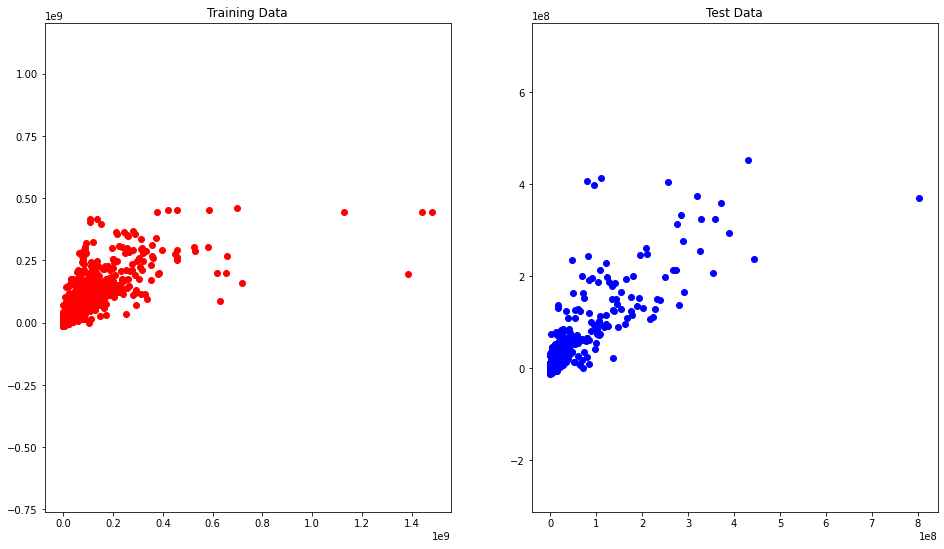

In [6]:
pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)
print('Training:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_train, pred_train), 
    median_absolute_error(y_train, pred_train),
    r2_score(y_train, pred_train)
))
print('\nTest:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_test, pred_test), 
    median_absolute_error(y_test, pred_test),
    r2_score(y_test, pred_test)
))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.plot(y_train, pred_train, 'ro')
ax1.set_title('Training Data')
ax1.axis('equal')
ax2.plot(y_test, pred_test, 'bo')
ax2.set_title('Test Data')
ax2.axis('equal')

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


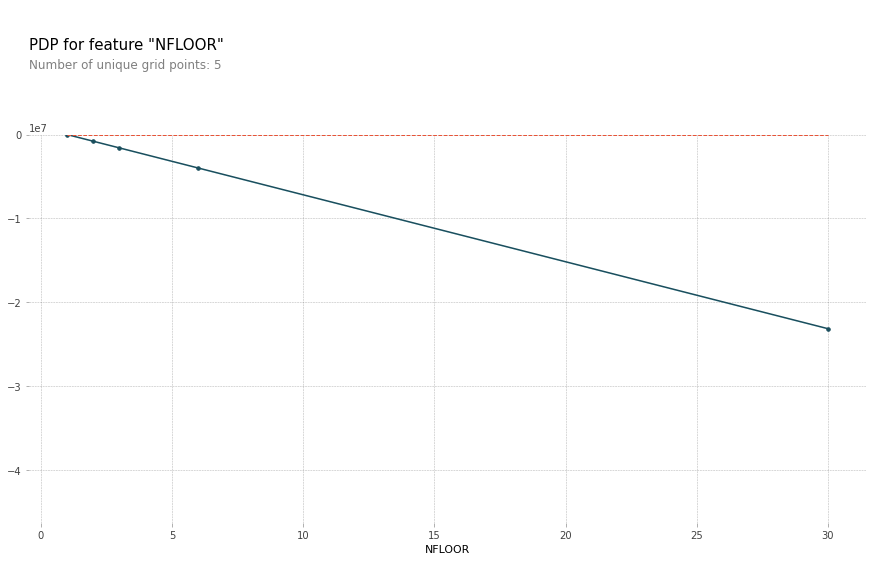

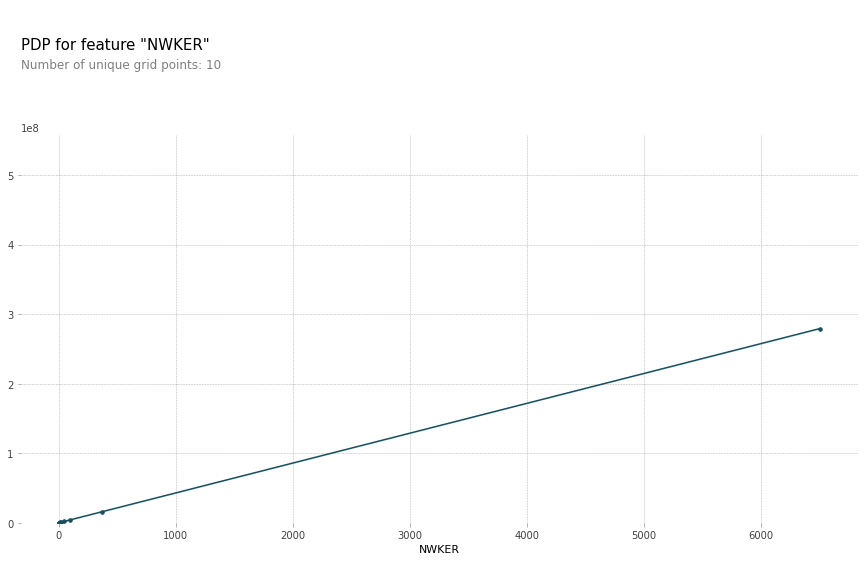

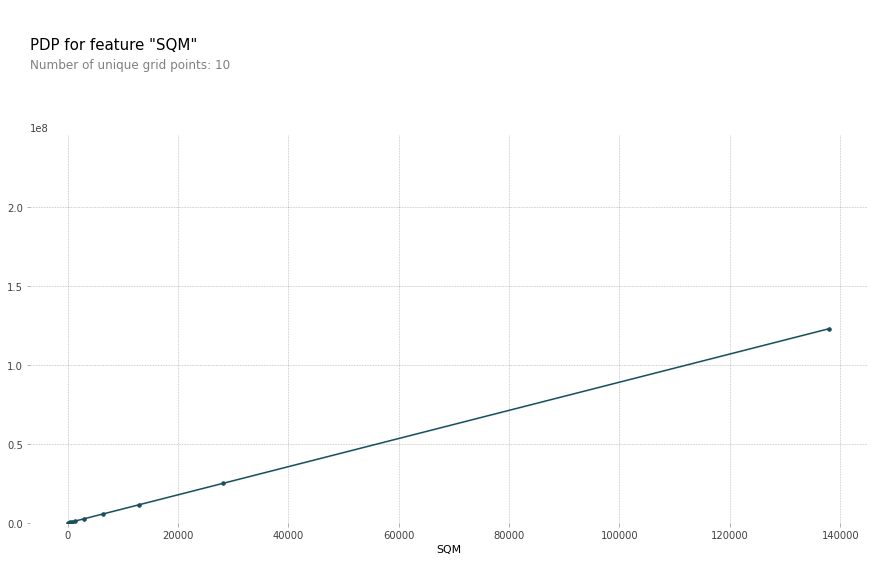

In [7]:
for inspect_feature in ['NFLOOR', 'NWKER', 'SQM']:
    pdp_goals = pdp.pdp_isolate(model=lr, 
                                dataset=data, 
                                model_features=features, 
                                feature=inspect_feature)
    pdp.pdp_plot(pdp_goals, inspect_feature)

# Random Forest Regressor

## Training

In [8]:
rf = RandomForestRegressor(random_state=1, n_estimators=64)    

# Create the parameter ranges
maxDepth = list(range(5,100,5)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(2,42,5) # Minimum samples required to split a node
minSamplesLeaf = range(1,101,10) # Minimum samples required at each leaf node
max_features = ['auto', 'sqrt', 'log2']

#Create the grid
randomGrid = {'max_depth': maxDepth,
              'min_samples_split': minSamplesSplit,
              'min_samples_leaf': minSamplesLeaf,
              'max_features': max_features}

# Create the random search object
rfRandom = RandomizedSearchCV(estimator=rf, 
                              param_distributions=randomGrid,
                              n_iter=512, 
                              cv=5, 
                              verbose=1, 
                              random_state=1, 
                              refit=True, 
                              n_jobs=-1)

# Perform the random search and find the best parameter set
rfRandom.fit(X_train, y_train)
rfWinner = rfRandom.best_estimator_
rfBestParams = rfRandom.best_params_

print(f'Best score for random forest: {rfRandom.best_score_}')

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best score for random forest: 0.6817268476915885


## Feature Importance

Feature ranking:
1. SQM (0.270610)
2. NWKER (0.264739)
3. NFLOOR (0.158521)
4. CLIMATE_Withheld to protect confidentiality (0.125406)
5. LBCS_6500 (0.077651)
6. LBCS_2400 (0.045549)
7. LBCS_5000 (0.020690)
8. LBCS_3000 (0.006692)
9. LBCS_2100 (0.006042)
10. LBCS_9000 (0.005252)
11. CLIMATE_Mixed-humid (0.003924)
12. CLIMATE_Very cold/Cold (0.003297)
13. LBCS_1300 (0.003172)
14. CLIMATE_Hot-dry/Mixed-dry/Hot-humid (0.002610)
15. LBCS_4300 (0.001875)
16. CLIMATE_Marine (0.001162)
17. LBCS_6100 (0.000978)
18. LBCS_6400 (0.000826)
19. LBCS_2500 (0.000694)
20. LBCS_6600 (0.000311)


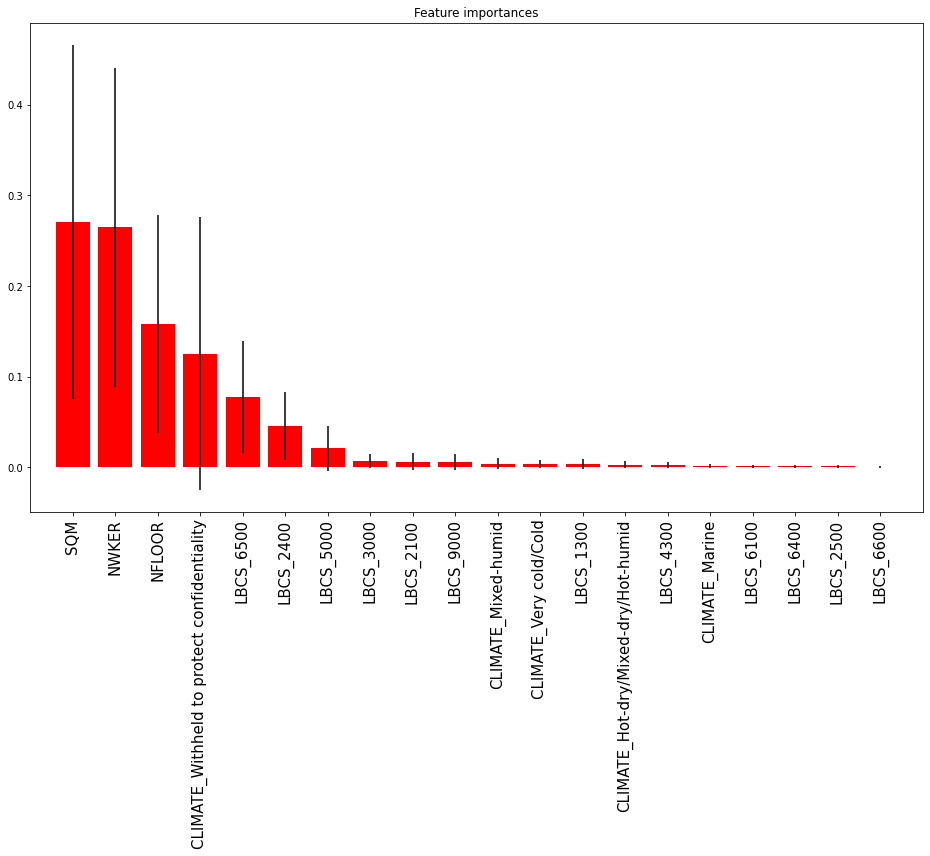

In [9]:
importances = rfWinner.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfWinner.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(features)):
    print("%d. %s (%f)" % (f+1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16, 9))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90, fontsize=15)
plt.xlim([-1, len(features)])
plt.show()

## Prediction Performance

Training:
MSE=558201437854314.6250, Median AE=490724.0333, r2=0.8601

Test:
MSE=515571588484601.1875, Median AE=706398.5611, r2=0.8178


(-40150849.6, 843168743.6, -29866653.55580872, 628360867.3393989)

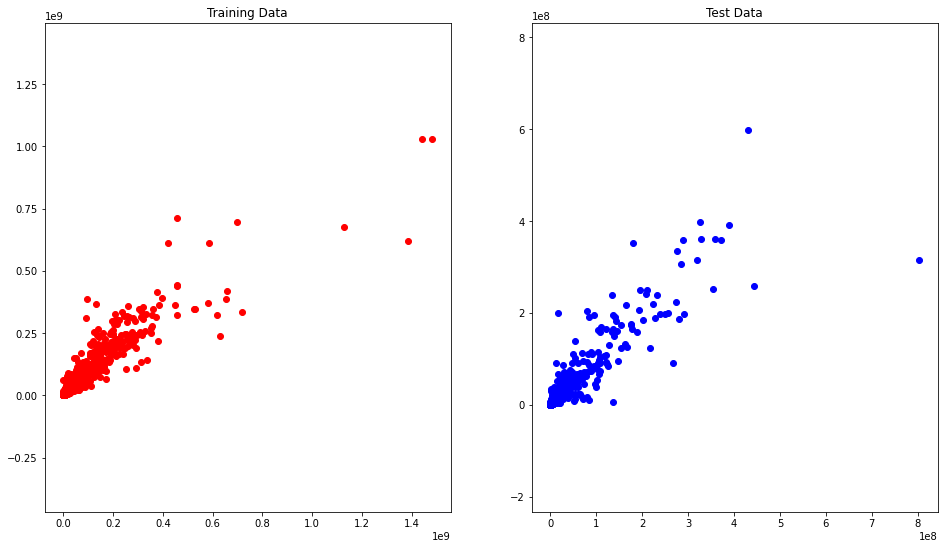

In [10]:
pred_train = rfWinner.predict(X_train)
pred_test = rfWinner.predict(X_test)
print('Training:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_train, pred_train), 
    median_absolute_error(y_train, pred_train),
    r2_score(y_train, pred_train)
))
print('\nTest:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_test, pred_test), 
    median_absolute_error(y_test, pred_test),
    r2_score(y_test, pred_test)
))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.plot(y_train, pred_train, 'ro')
ax1.set_title('Training Data')
ax1.axis('equal')
ax2.plot(y_test, pred_test, 'bo')
ax2.set_title('Test Data')
ax2.axis('equal')

## Partial Dependence Plot

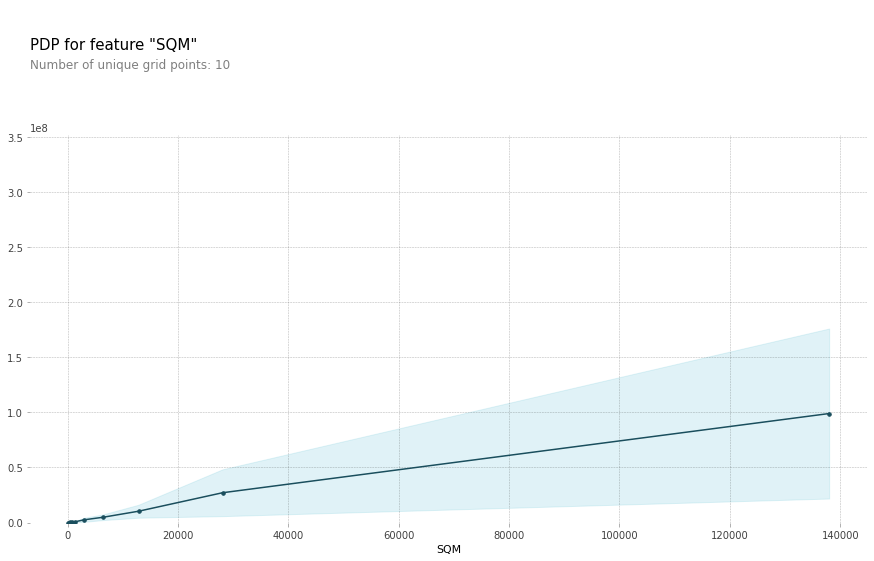

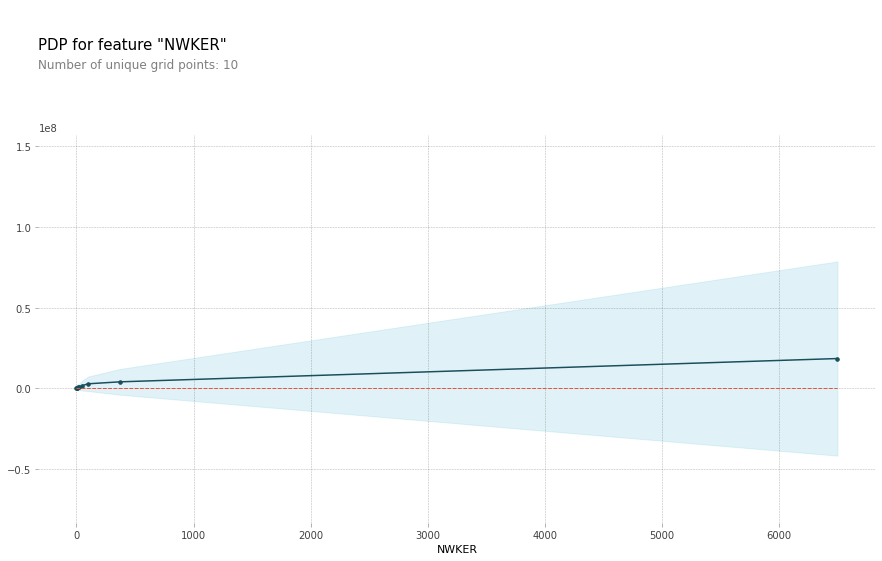

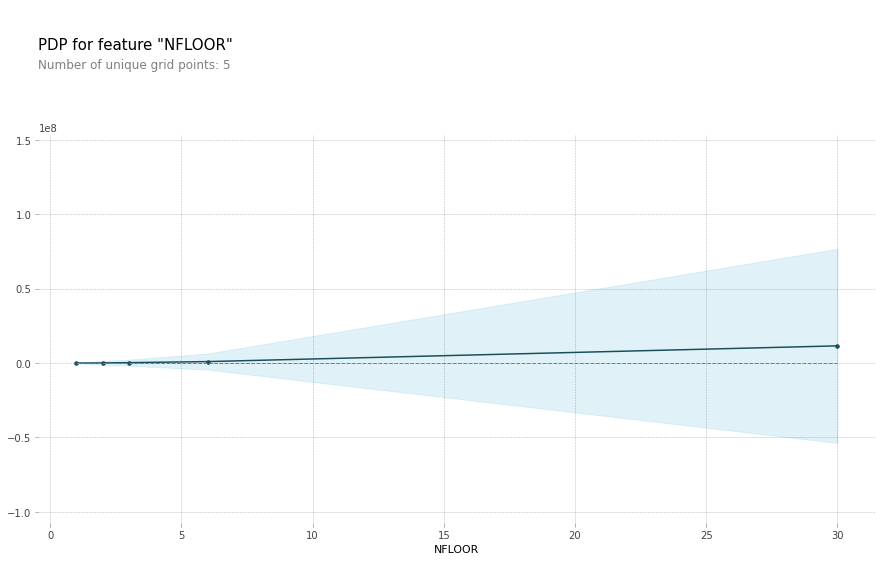

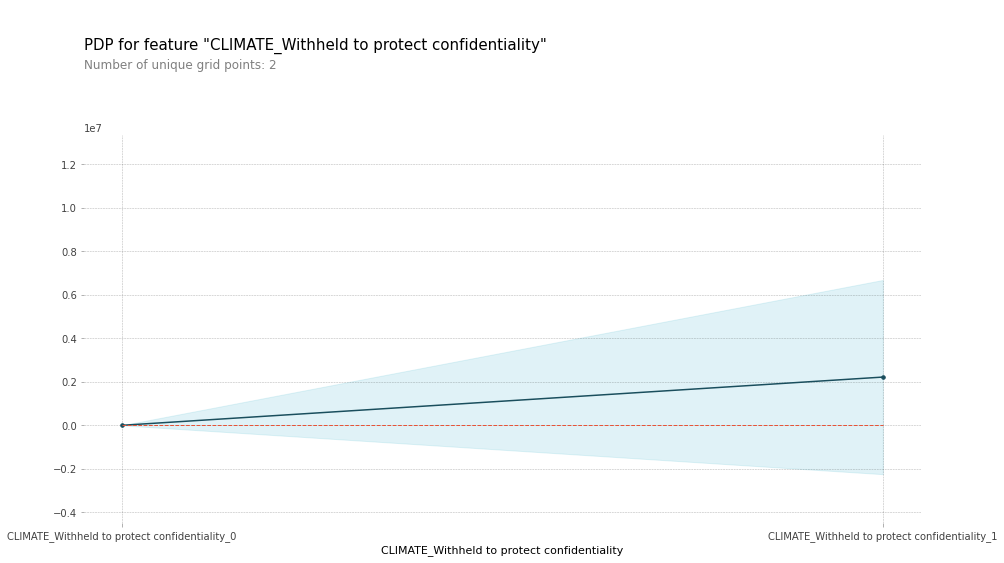

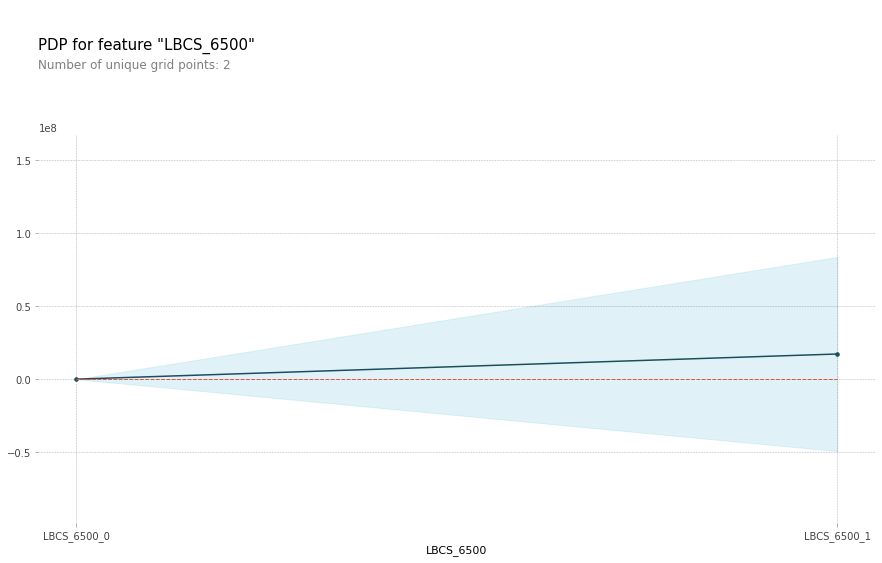

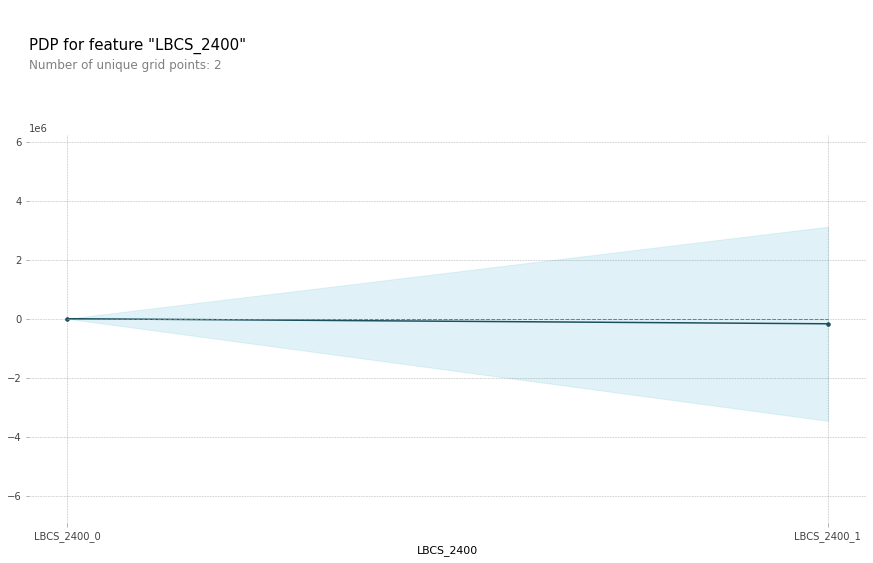

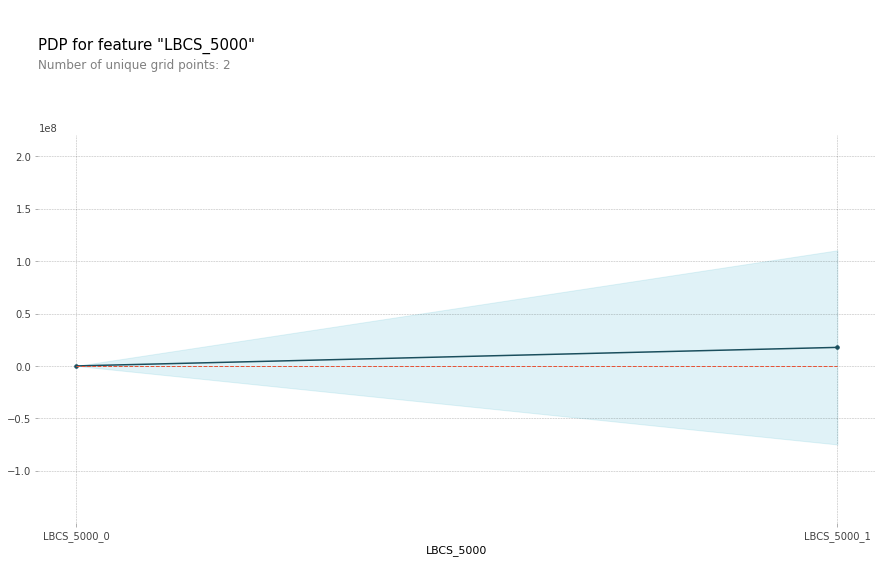

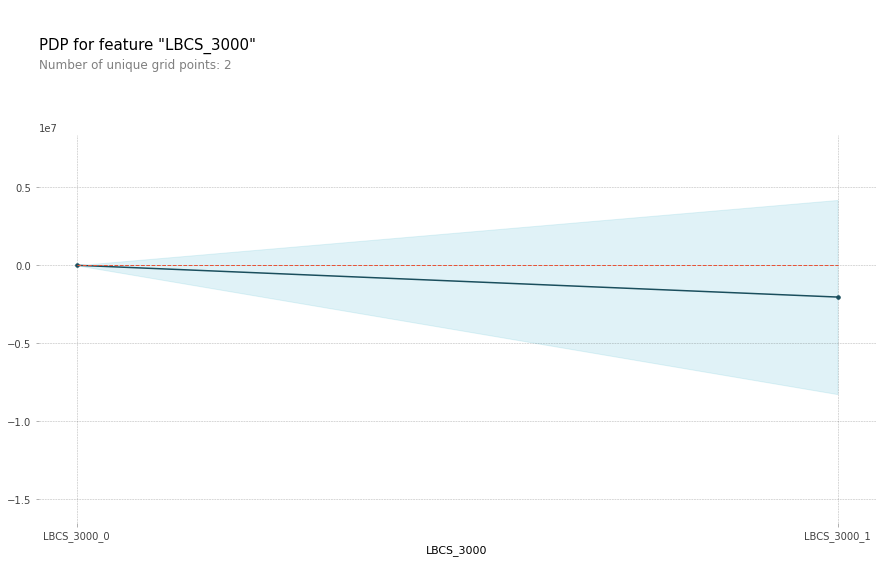

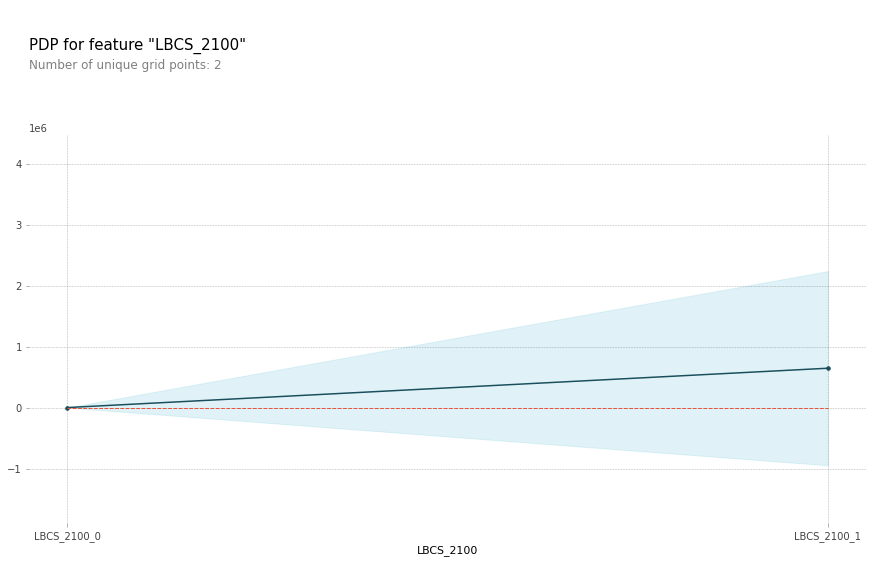

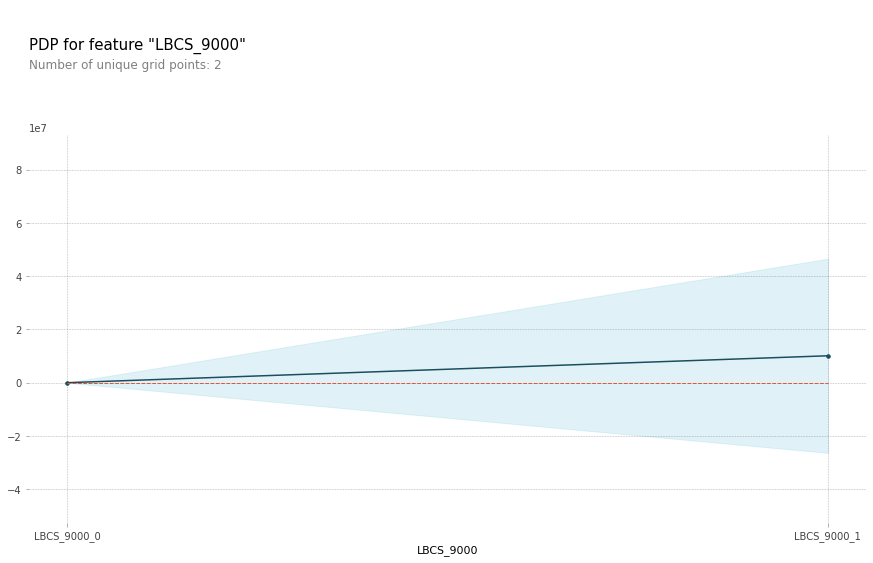

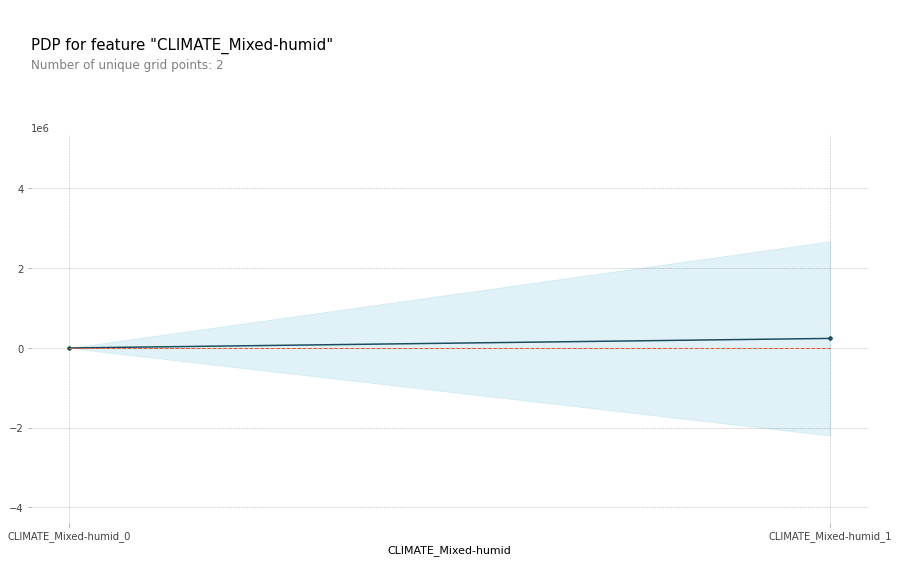

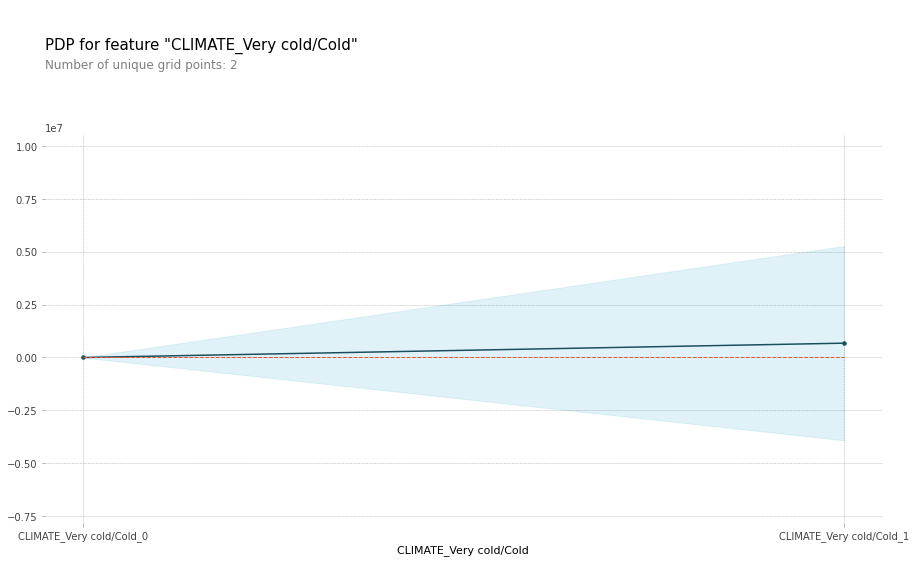

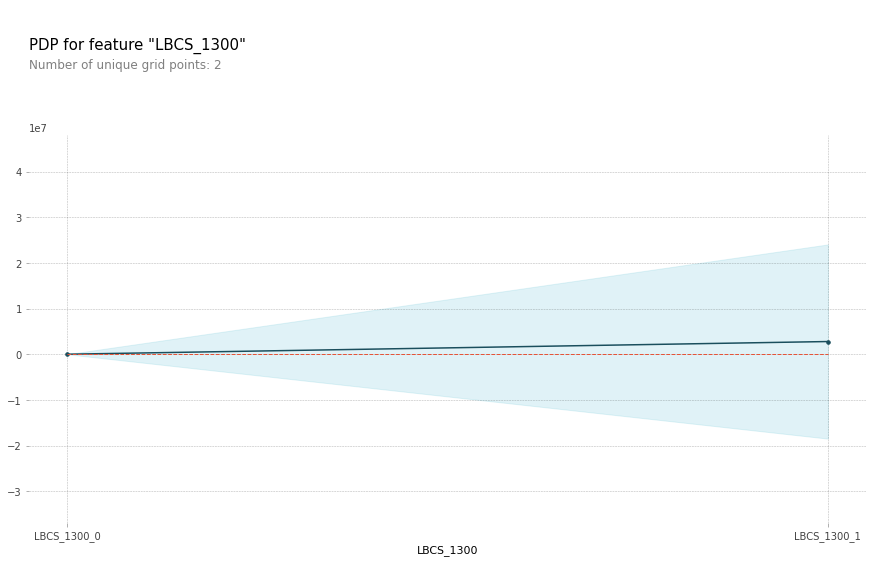

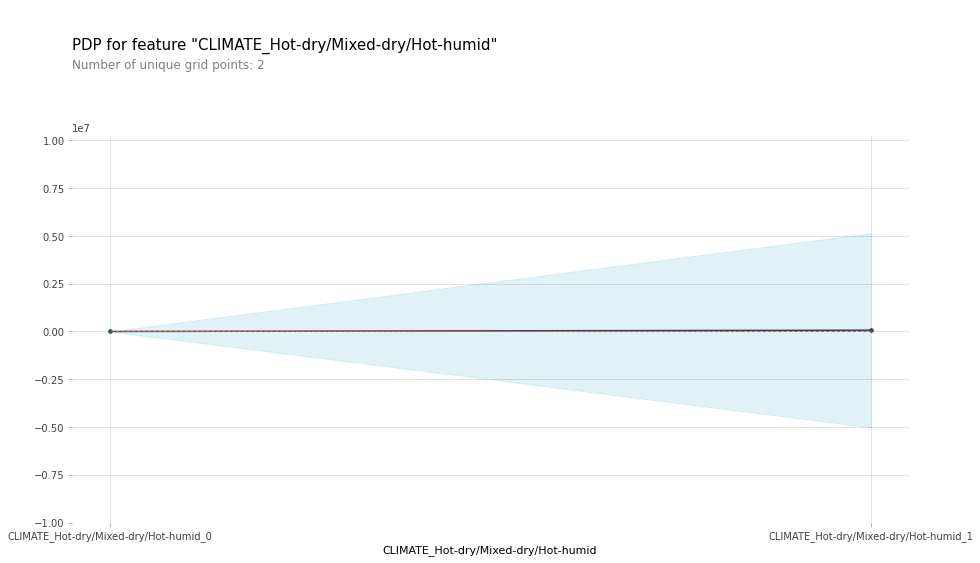

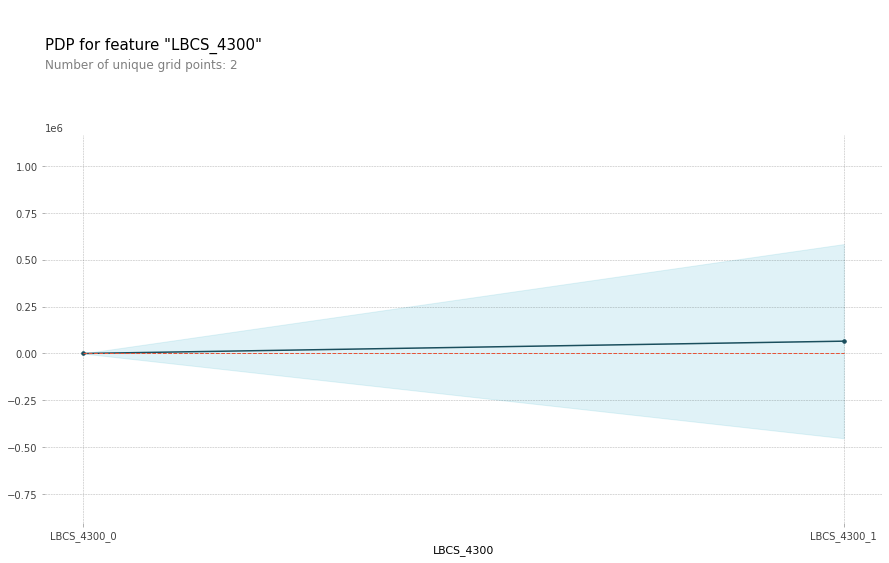

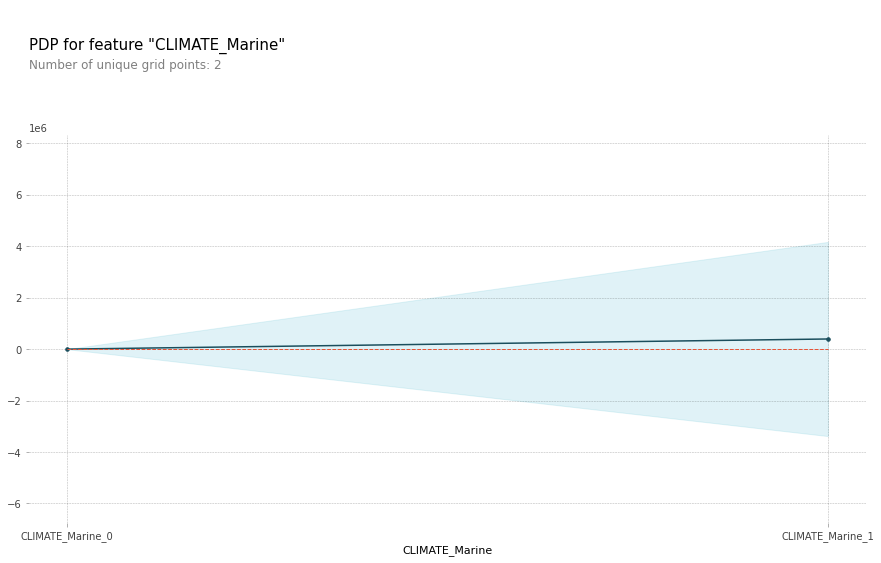

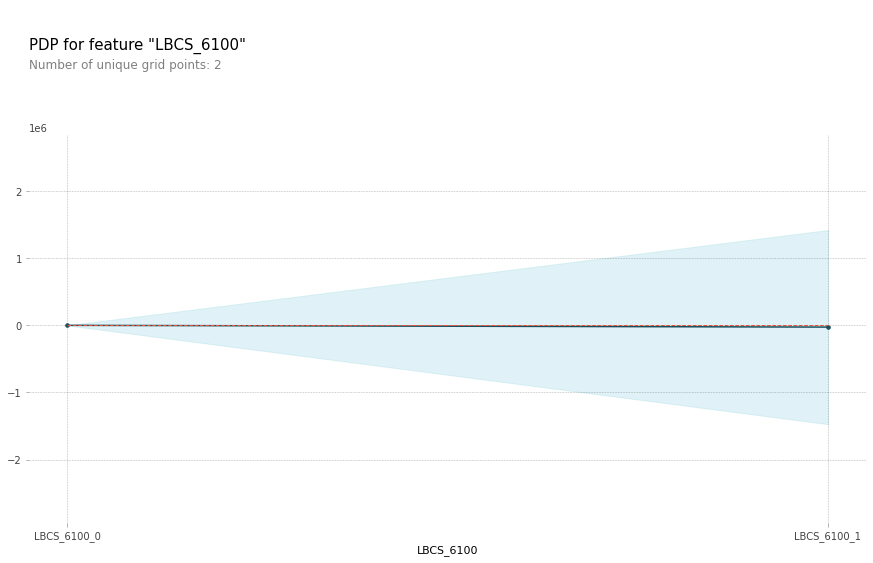

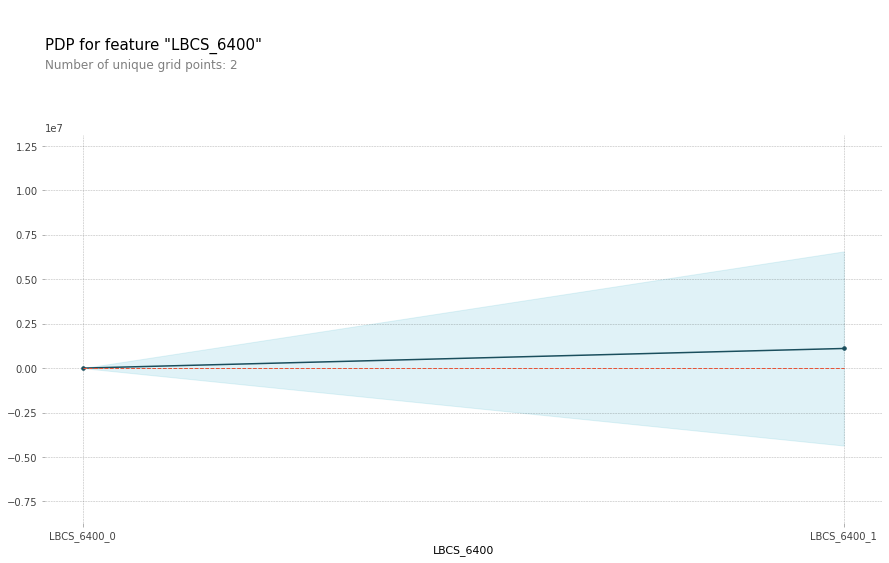

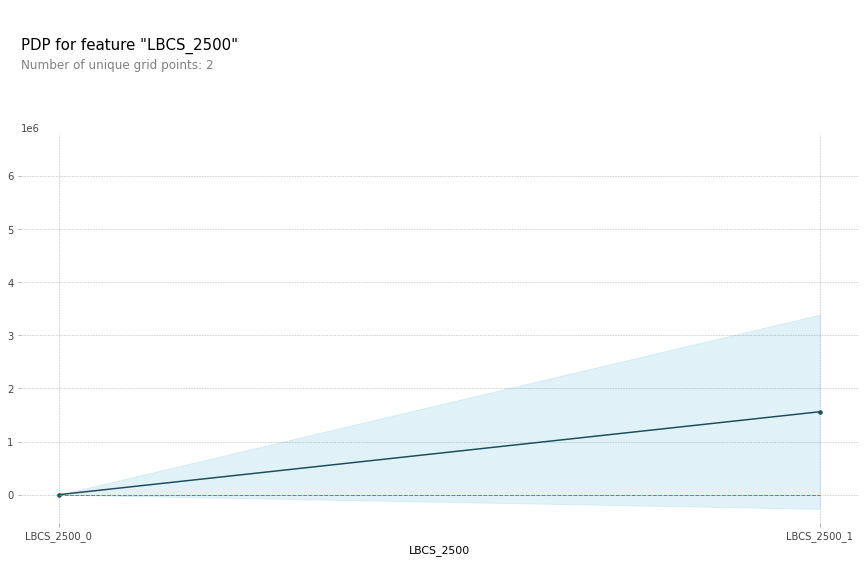

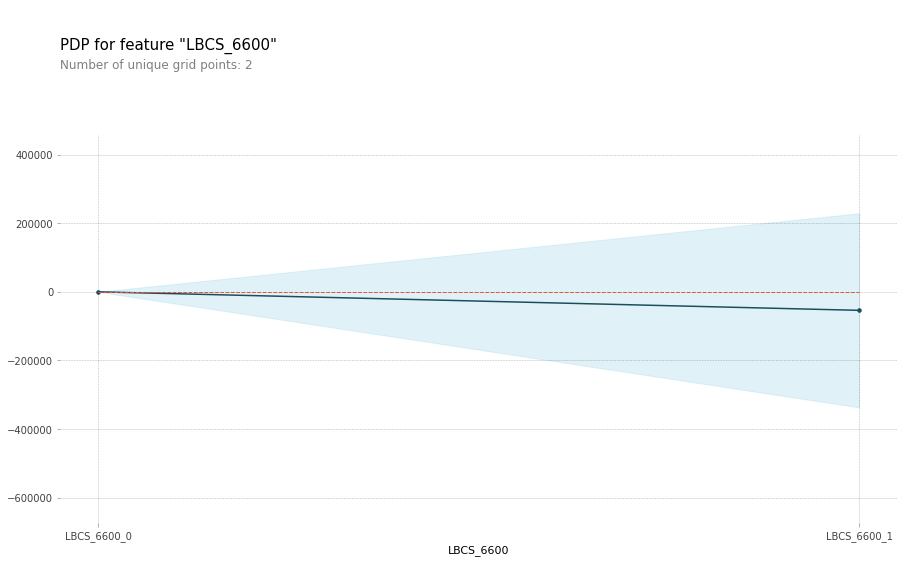

In [11]:
rf.fit(X_train, y_train)
for idx in range(len(features)):
    inspect_feature = features[indices[idx]]
    pdp_goals = pdp.pdp_isolate(model=rf, 
                                dataset=data, 
                                model_features=features, 
                                feature=inspect_feature)
    pdp.pdp_plot(pdp_goals, inspect_feature)
#     plt.show()

# Residential Model

In [12]:
data = pd.read_csv('cities/shenzhen/raw/building_energy/recs2015_public_v4.csv')

data.loc[data['NUMBERAC'] < 0, 'NUMBERAC'] = 0
data = data.loc[data['TYPEHUQ'].isin([2,3,4,5])]
data['SQM'] = (data['TOTCSQFT'] + data['TOTUCSQFT']) * 0.092

numerical_regressors = ['TOTROOMS', 'BEDROOMS', 'SQM', 'NHSLDMEM', 'NUMFRIG', 'NUMBERAC', 'TVCOLOR']
categorical_regressors = ['CLIMATE_REGION_PUB', 'FUELHEAT']
target = 'TOTALBTU'

data = data[numerical_regressors + categorical_regressors + [target]]
data = data.loc[~data[target].isnull()]
data.head()

,TOTROOMS,BEDROOMS,SQM,NHSLDMEM,NUMFRIG,NUMBERAC,TVCOLOR,CLIMATE_REGION_PUB,FUELHEAT,TOTALBTU
0,7,3,203.136,4,1,0,2,Hot-Dry/Mixed-Dry,1,48974.570
1,4,2,69.828,2,1,4,2,Hot-Humid,5,41534.000
2,9,4,210.496,4,2,2,4,Mixed-Humid,1,96548.160
3,7,3,273.516,1,2,0,5,Mixed-Humid,2,89284.345
4,6,3,117.208,3,2,0,5,Cold/Very Cold,1,36582.146


In [13]:
features = numerical_regressors.copy()
for cat_reg in categorical_regressors:
    new_dummies = pd.get_dummies(data[cat_reg], prefix=cat_reg, drop_first=False)
    data = pd.concat([data, new_dummies], axis=1)
    features += new_dummies.columns.tolist()

X = np.array(data[features])
y = np.array(data[target])
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1)
print('Traning data shape: ', X_train.shape)
print('Traning target shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test target shape: ', y_test.shape)

Traning data shape:  (4320, 19)
Traning target shape:  (4320,)
Test data shape:  (1080, 19)
Test target shape:  (1080,)


In [14]:
t0 = time.time()
rf = RandomForestRegressor(random_state=1, n_estimators=64)    

# Create the parameter ranges
maxDepth = list(range(5,100,5)) # Maximum depth of tree
maxDepth.append(None)
minSamplesSplit = range(2,42,5) # Minimum samples required to split a node
minSamplesLeaf = range(1,101,10) # Minimum samples required at each leaf node
max_features = ['auto', 'sqrt', 'log2']

#Create the grid
randomGrid = {'max_depth': maxDepth,
              'min_samples_split': minSamplesSplit,
              'min_samples_leaf': minSamplesLeaf,
              'max_features': max_features}

# Create the random search object
rfRandom = RandomizedSearchCV(estimator=rf, 
                              param_distributions=randomGrid,
                              n_iter=512, 
                              cv=5, 
                              verbose=1, 
                              random_state=1, 
                              refit=True, 
                              n_jobs=-1)

# Perform the random search and find the best parameter set
rfRandom.fit(X_train, y_train)
rfWinner = rfRandom.best_estimator_
rfBestParams = rfRandom.best_params_

print(f'Best score for random forest: {rfRandom.best_score_}')
t1 = time.time()
print('{:4.4f} seconds elasped'.format(t1-t0))

Fitting 5 folds for each of 512 candidates, totalling 2560 fits
Best score for random forest: 0.6132815310427447
18.1145 seconds elasped


Training:
MSE=568865412.3095, Median AE=12809.4214, r2=0.7459

Test:
MSE=885241316.1430, Median AE=15167.5985, r2=0.6244


(-22467.645800000002,
 480014.28579999995,
 11633.082283017364,
 198527.1176326972)

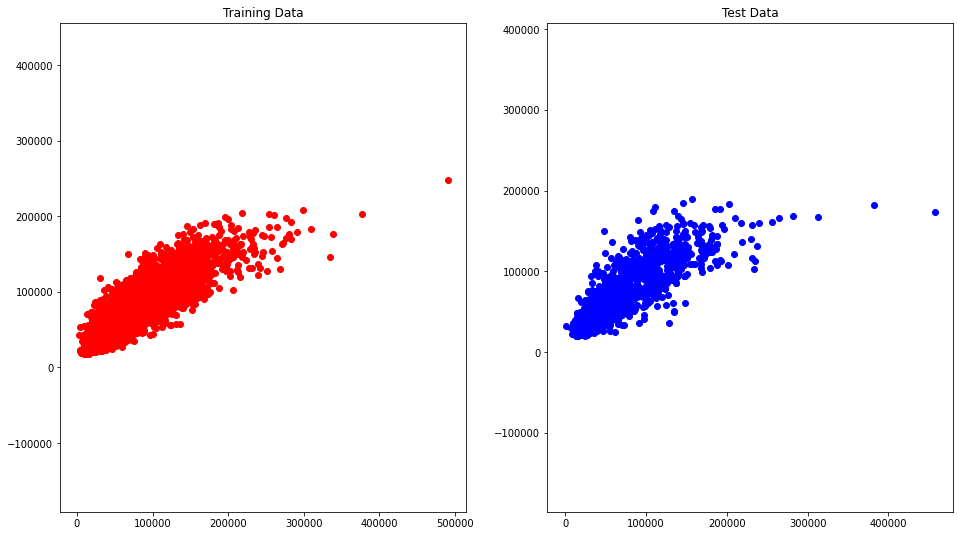

In [15]:
pred_train = rfWinner.predict(X_train)
pred_test = rfWinner.predict(X_test)
print('Training:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_train, pred_train), 
    median_absolute_error(y_train, pred_train),
    r2_score(y_train, pred_train)
))
print('\nTest:\nMSE={:4.4f}, Median AE={:4.4f}, r2={:4.4f}'.format(
    mean_squared_error(y_test, pred_test), 
    median_absolute_error(y_test, pred_test),
    r2_score(y_test, pred_test)
))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
ax1.plot(y_train, pred_train, 'ro')
ax1.set_title('Training Data')
ax1.axis('equal')
ax2.plot(y_test, pred_test, 'bo')
ax2.set_title('Test Data')
ax2.axis('equal')

Feature ranking:
1. SQM (0.268328)
2. TOTROOMS (0.138967)
3. BEDROOMS (0.119948)
4. FUELHEAT_5 (0.089886)
5. NUMFRIG (0.063400)
6. FUELHEAT_1 (0.049250)
7. TVCOLOR (0.045853)
8. NHSLDMEM (0.040538)
9. CLIMATE_REGION_PUB_Cold/Very Cold (0.038033)
10. CLIMATE_REGION_PUB_Hot-Dry/Mixed-Dry (0.028905)
11. FUELHEAT_3 (0.021446)
12. NUMBERAC (0.019283)
13. CLIMATE_REGION_PUB_Mixed-Humid (0.017162)
14. CLIMATE_REGION_PUB_Marine (0.014797)
15. FUELHEAT_-2 (0.014275)
16. FUELHEAT_7 (0.012896)
17. CLIMATE_REGION_PUB_Hot-Humid (0.009961)
18. FUELHEAT_2 (0.006456)
19. FUELHEAT_21 (0.000616)


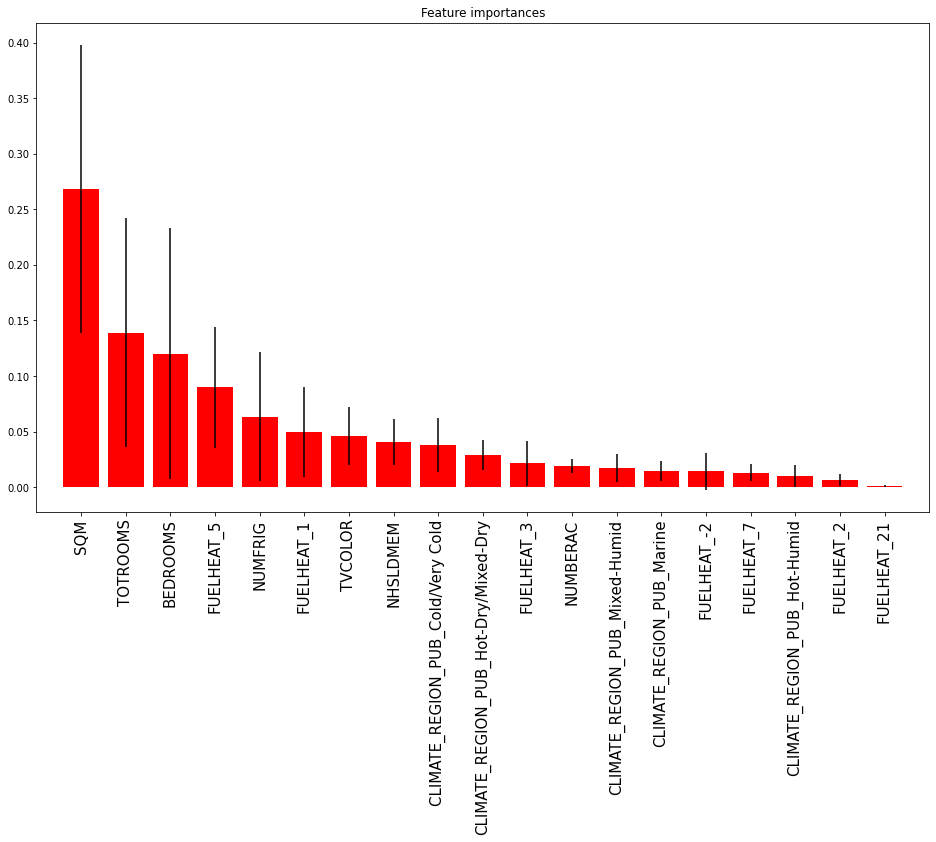

In [16]:
importances = rfWinner.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfWinner.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(features)):
    print("%d. %s (%f)" % (f+1, features[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(16, 9))
plt.title("Feature importances")
plt.bar(range(len(features)), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90, fontsize=15)
plt.xlim([-1, len(features)])
plt.show()

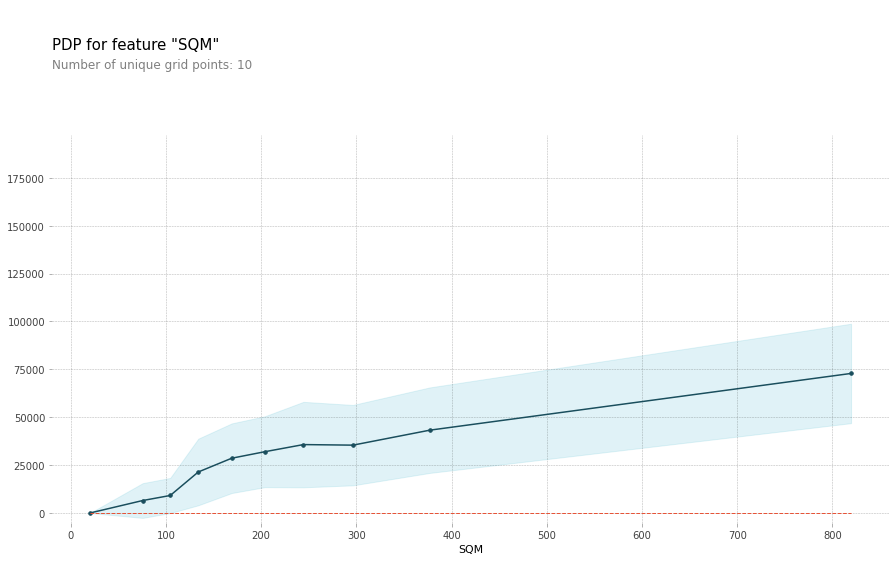

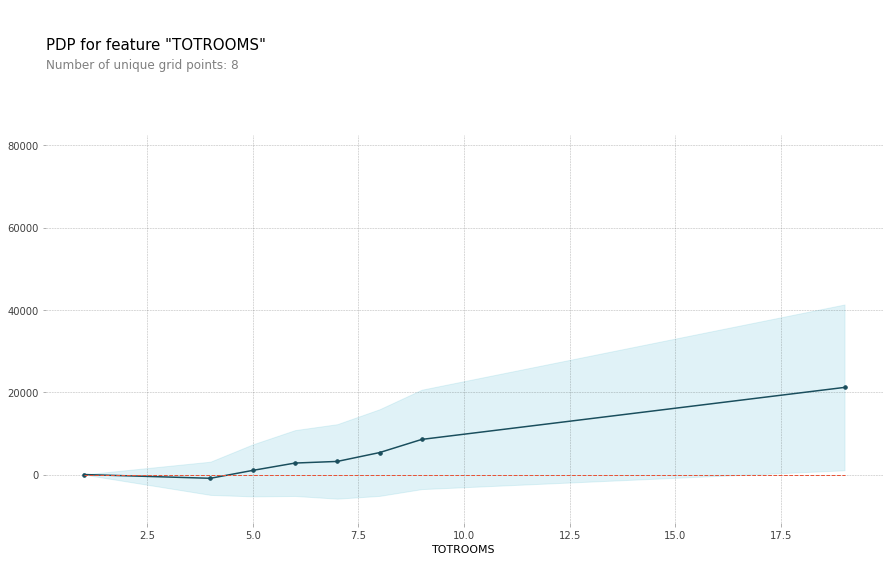

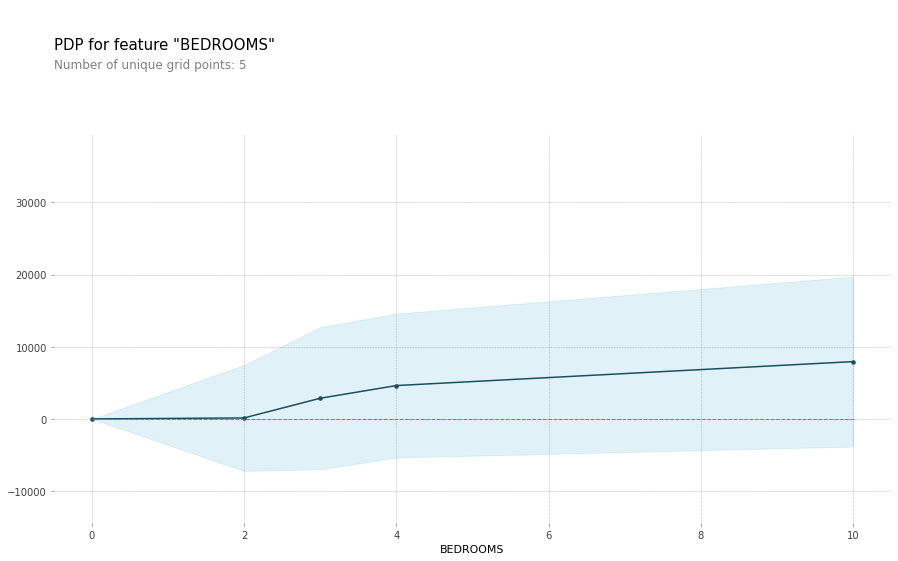

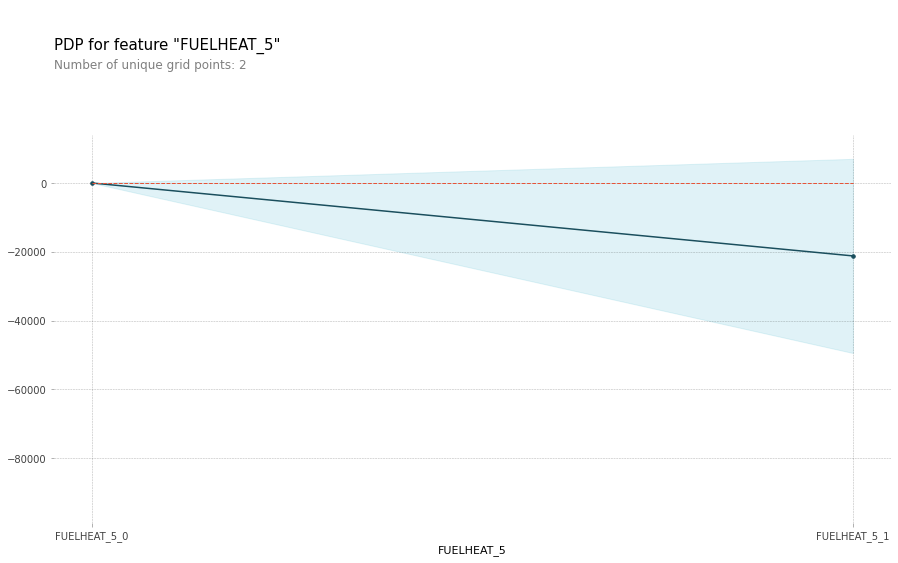

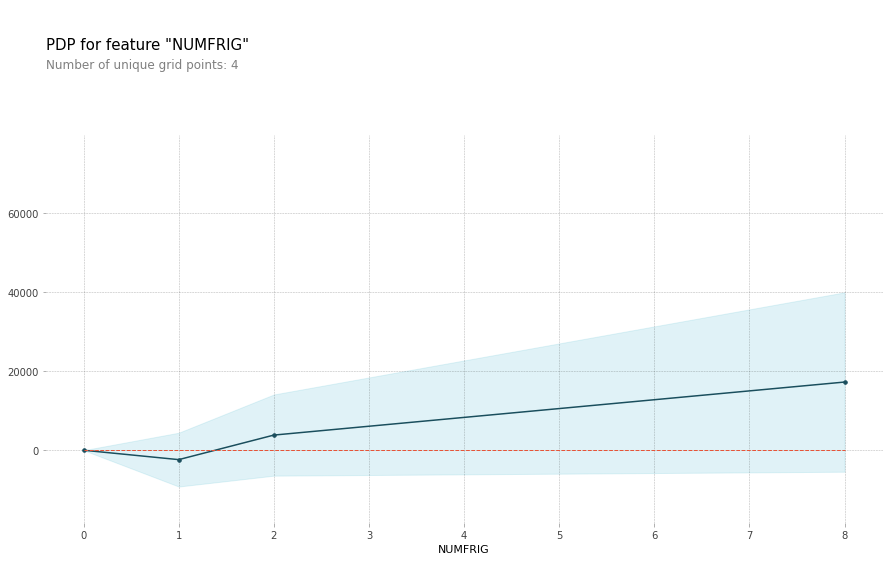

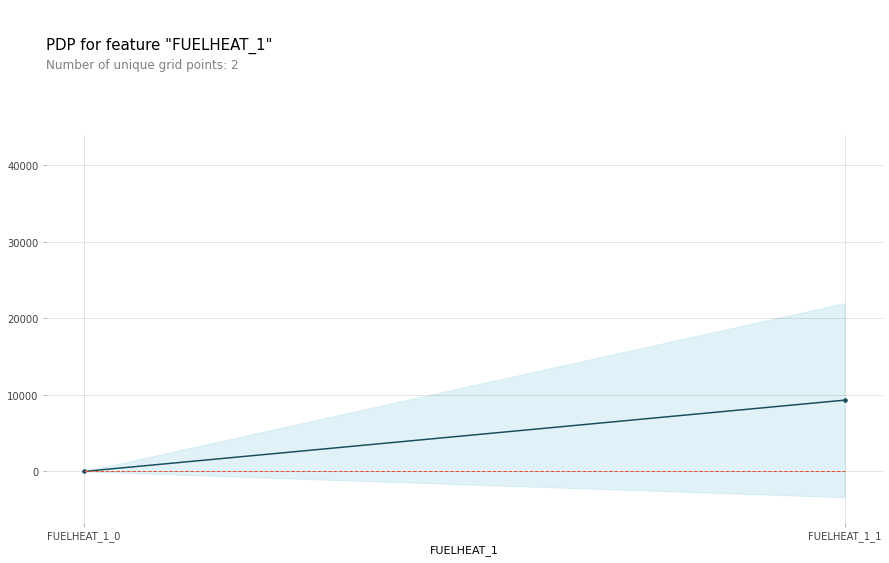

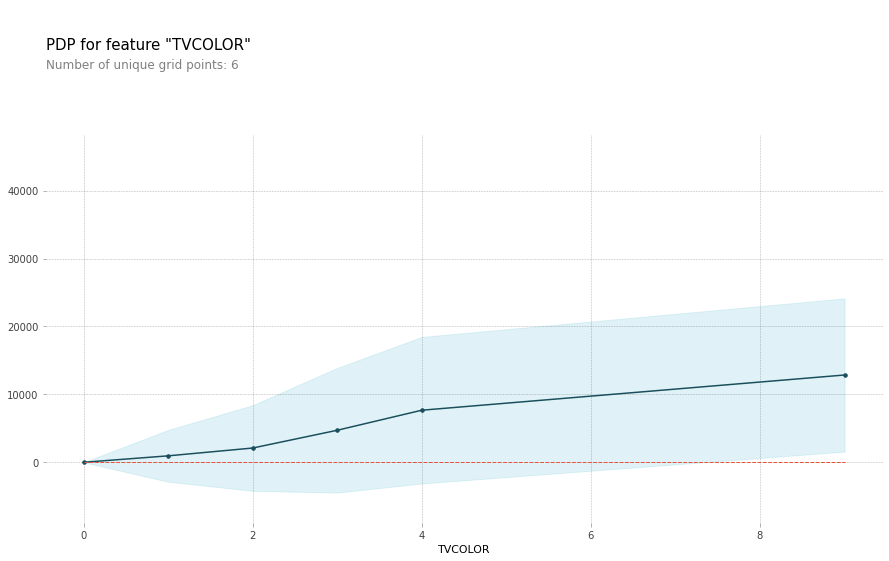

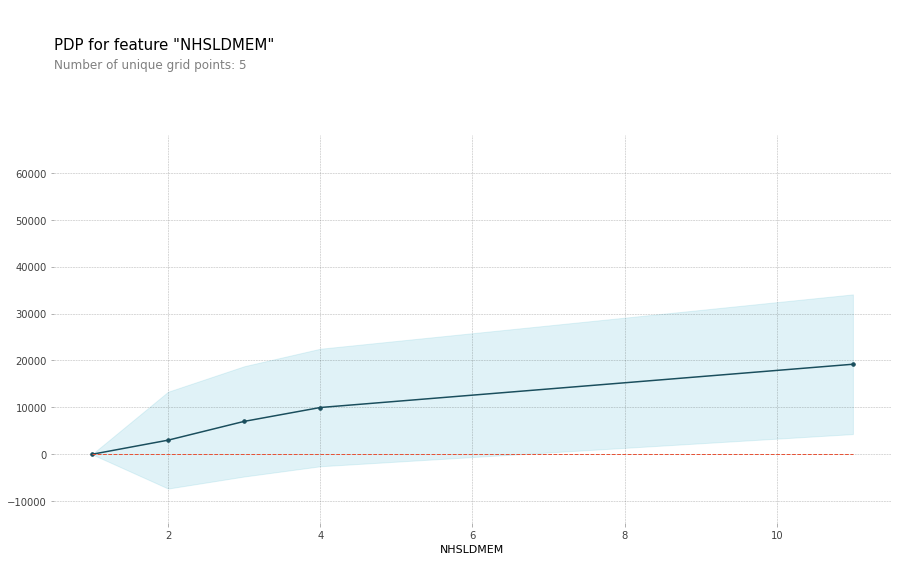

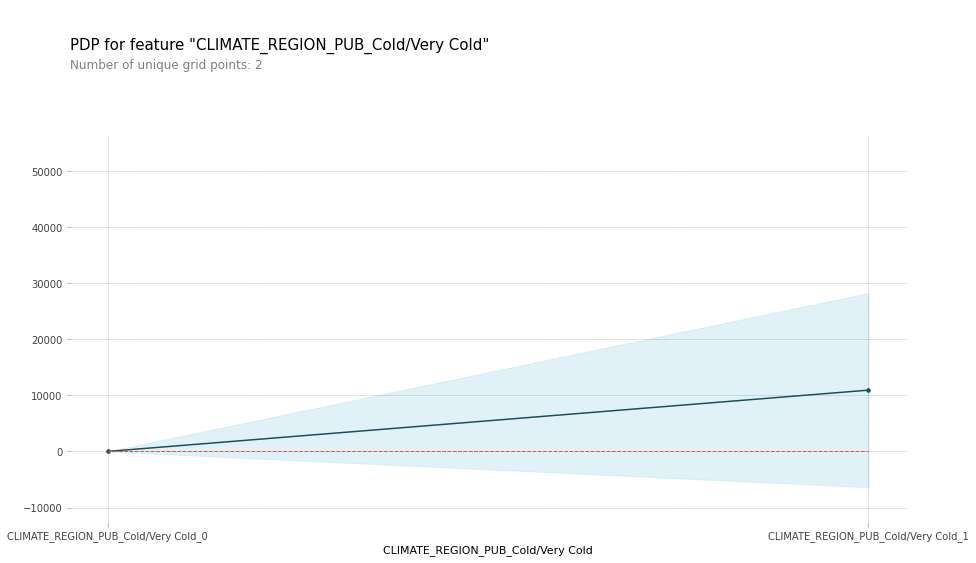

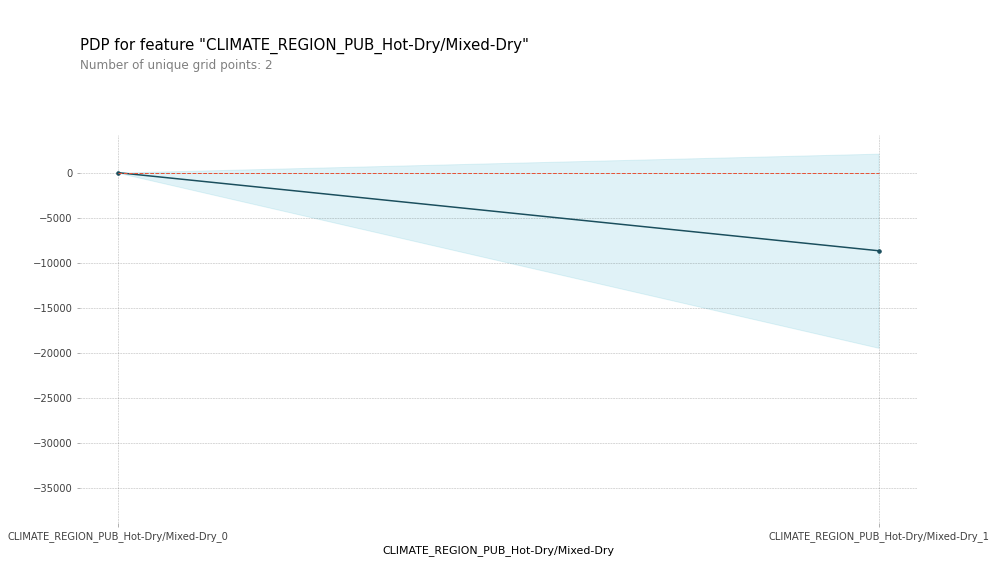

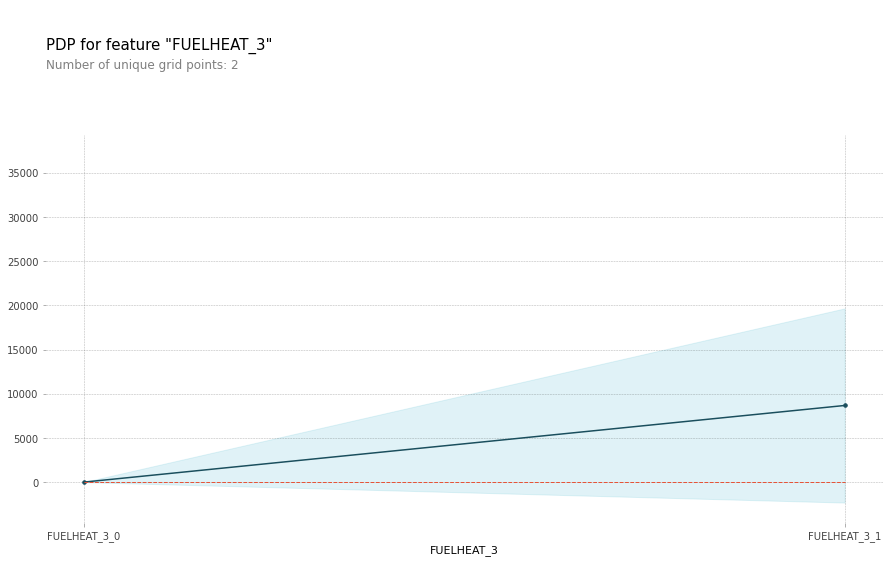

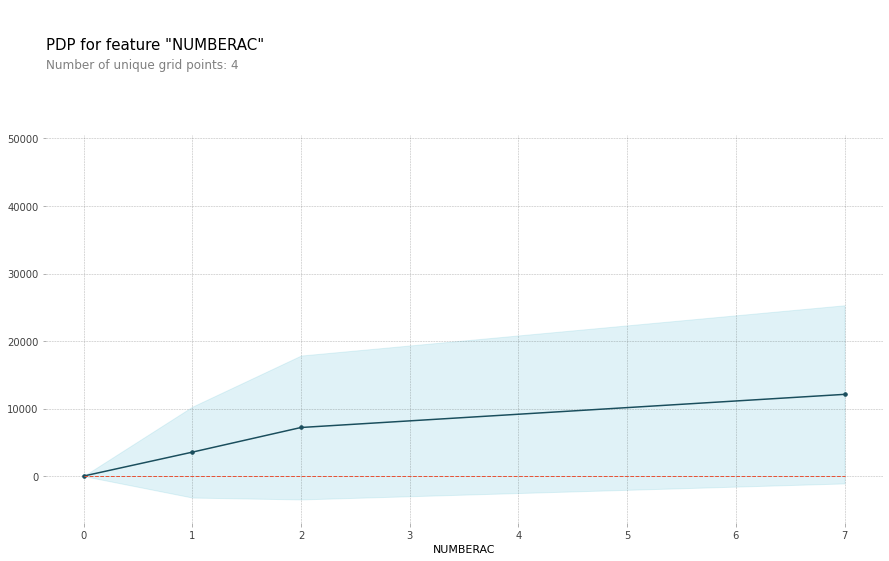

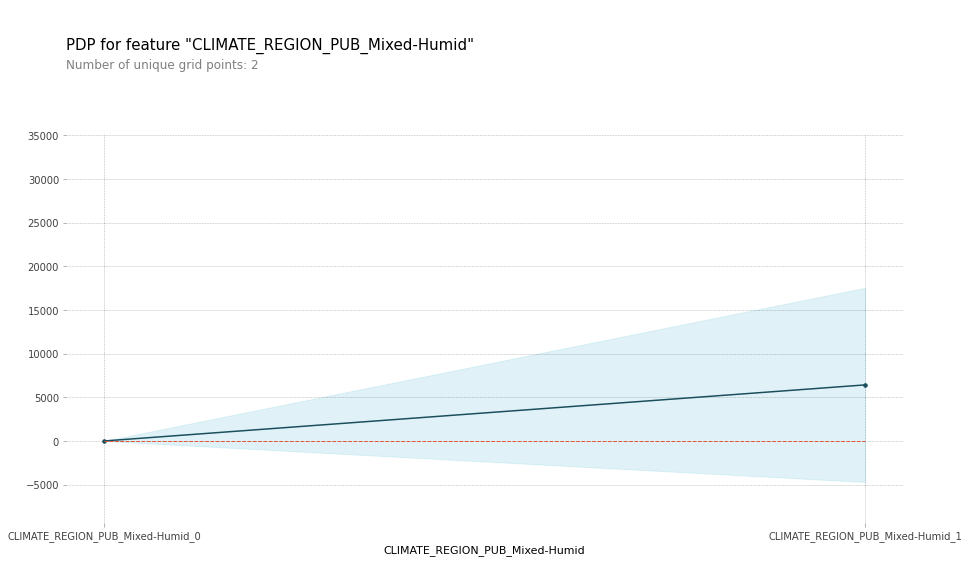

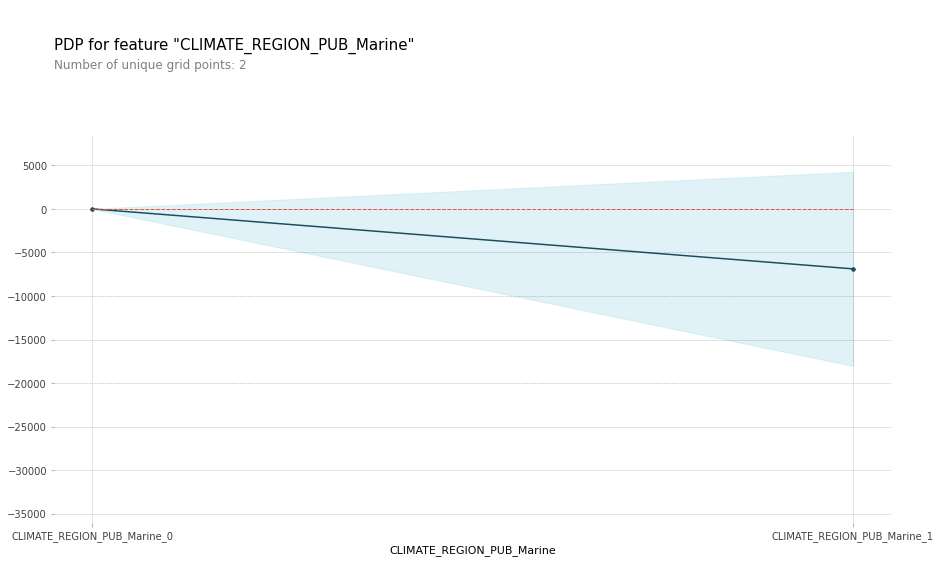

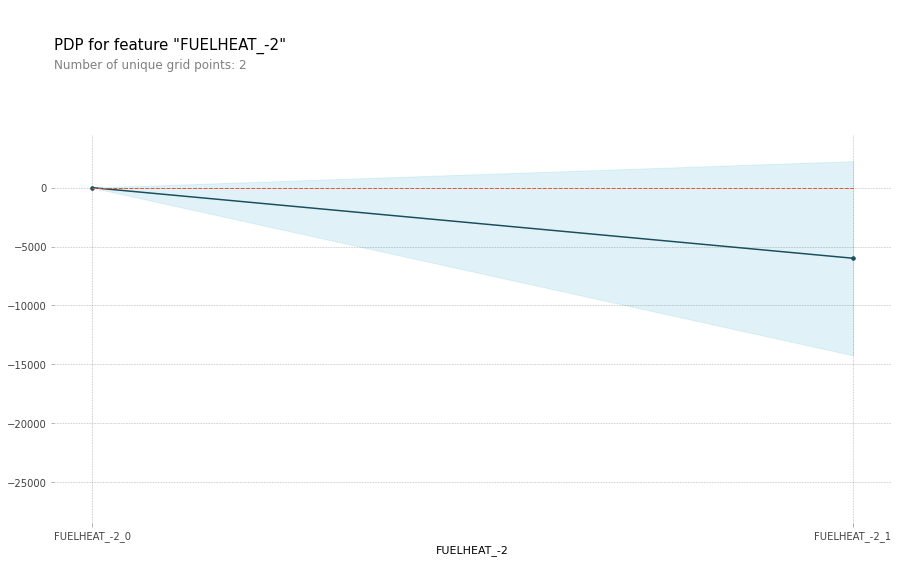

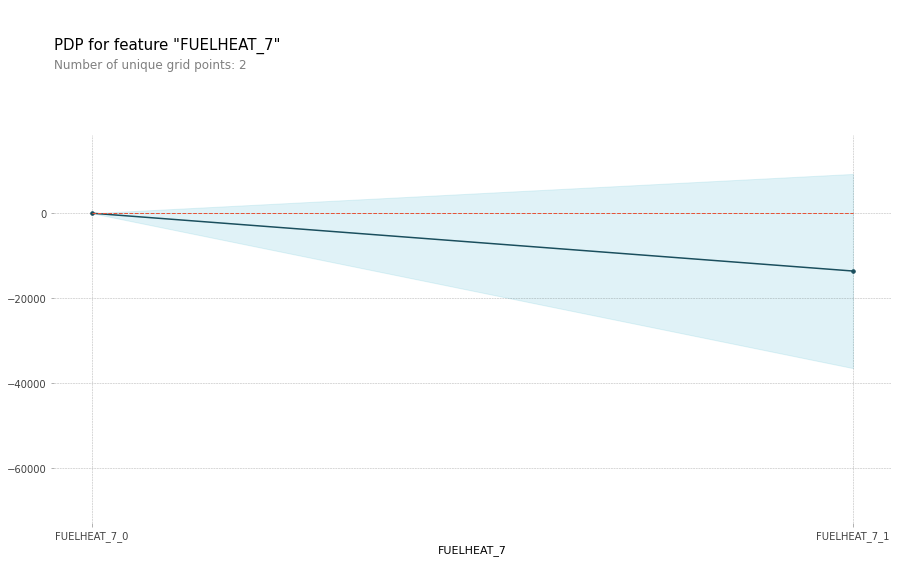

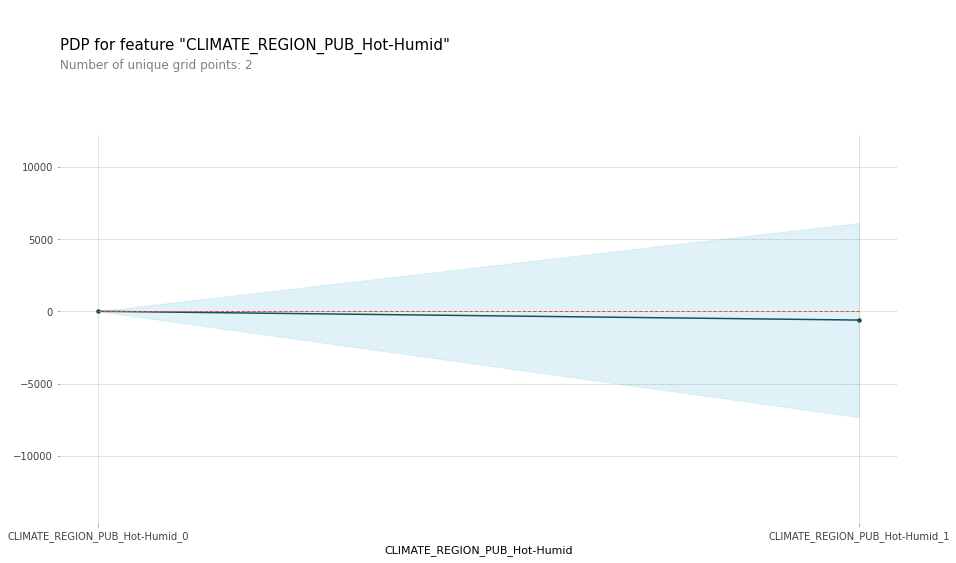

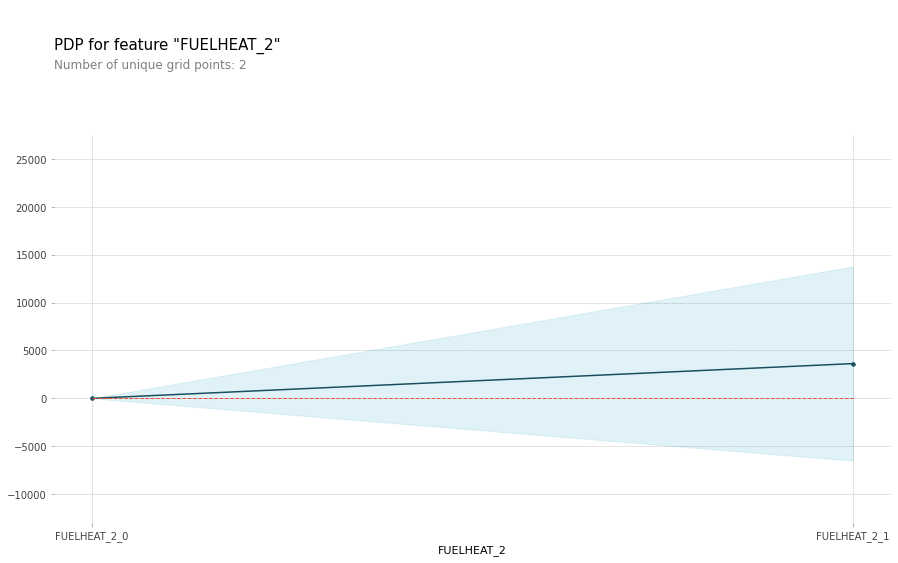

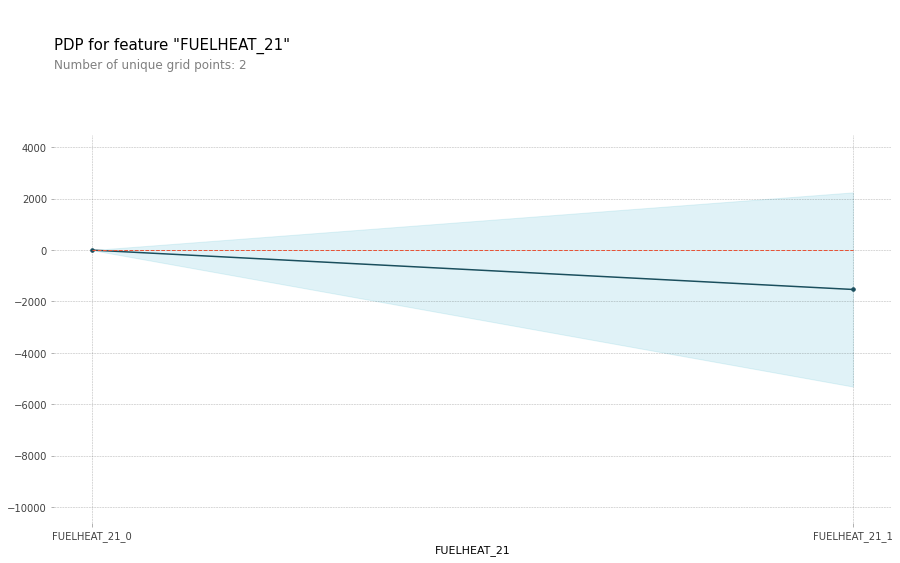

In [17]:
rf.fit(X_train, y_train)
for idx in range(len(features)):
    inspect_feature = features[indices[idx]]
    pdp_goals = pdp.pdp_isolate(model=rf, 
                                dataset=data, 
                                model_features=features, 
                                feature=inspect_feature)
    pdp.pdp_plot(pdp_goals, inspect_feature)
#     plt.show()